## Энергетический оракул
Ноутбук команды #12

Работа выполнена на основе модели LightGBM


### 1. Подготовка данных

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True )

random_state = 12345
NUM_ITERATIONS = 5000

FEATURES = 'base feature'

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### 1.1 Функции для расшифровки прогноза погоды в колонке 'weather_pred'

In [37]:
# Расшифровка прогноза в колонке 'weather_pred'

# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

#### 1.2 Функции для загрузки данных о ВВП 
данные загружаются из файла 'data/VVP.csv'

Некоторые научные работы указывают на прямую связь величины потребления электричества и показателя ВВП, который отражает ситуацию в экономике. Данные по экономике публикуются различными министерствами с разной периодичностью. Для использования в работе были взяты фактические данные по ВВП с сайта investing, который агрегирует публикации Минэкономразвития. Данные за месяц побликуются с месячной задержкой, поэтому модель использует для прогнозирования данные за прошлые месяцы, которые известны.   
  
Ссылка на данные: https://ru.investing.com/economic-calendar/russian-monthly-gdp-407


In [38]:
# Функция добавляет данные о ВВП из файла 'data/VVP.csv' в датасет

def add_vvp2(data, file_source = 'data/VVP.csv'):
    """
    сырой датафрем подаем на вход
    """
    # обработаем файл с динамикой ВВП
    vvp = pd.read_csv(file_source)
    # преобразуем дату файла-источника в формат datetime64 и дропнем один столбик
    vvp['date'] = pd.to_datetime(vvp['date'], format ='%Y-%m-%d %H:%M:%S')
    vvp.drop('for_month',axis=1,inplace=True) 
    
    # обработаем основной фрейм - создадим столбец для соединения, который потом удалим
    data['date_temp'] = pd.to_datetime(data['date'], format = '%Y-%m-%d' )
    data['date_temp'] = data['date_temp'] + pd.to_timedelta(data['time'] , 'H')
    
    # соединяем основной фрейм и ВВП по дате объявления показтеля ВВП
    for idx in reversed(vvp.index):
        data.loc[data['date_temp']>=vvp.date[idx],'VVP'] = vvp.VVP_perc[idx]
        
    data.drop('date_temp',axis=1,inplace=True)   

    return data

#### 1.3 Функции для загрузки архива данных о фактической погоде
данные загружаются из файла 'data/preprocessing_loaded_table.csv'

Изначально данные для формирования таблицы "preprocessing_loaded_table" были взяты из с сайта [https://rp5.ru](https://rp5.ru/Архив_погоды_в_Храброво,_им._императрицы_Елизаветы_Петровны_(аэропорт),_METAR), где хранятся архивы погоды в аэрапорту Калининграда, за период с 31.12.2018 по 30.09.2023

Описание данных в таблице:
- Местное время в Храброво / им. императрицы Елизаветы Петровны (аэропорт) - Дата / Местное время
- T -  Темпиратура воздуха
- Po - Давление на уровне станции
- P - Давление приведённое к уровню моря
- U - Относительная влажность
- DD - Направление ветра
- Ff - Скорость ветра
- ff10 - Максимальное значение порыва ветра
- WW - Особое явление текущей погоды (осадки)
- W'W' - Явление недавней погоды, имеющее оперативное значение
- с - Общая облачность
- VV - Горизонтальная дальность видимости
- Td - Темпиратура точки росы

Данные, которые были взяты из данной таблицы и загружаются из 'data/preprocessing_loaded_table.csv':
- P - не подверглось изменению
- U - не подверглось изменению
- Td - не подверглась изменению

 WW - разделили на 4 категории:
- Нет осадков (где были пропуски)
- слабый дождь
- сильный дождь
- снег

DD - создали 4 столбца, соответствующих сторонам горизонта, которые принимали значения 0; 0.5 и 1 в зависимости от силы ветра в конкретном направлении
- N - north
- S - south
- W - west
- E - east

В дальнейшем эти данные использовались с лагом в сутки: в поля на завтрашний день записывались данные сегодняшнего.

In [39]:
# Функции для работы с данными о фактической погоде из 'data/preprocessing_loaded_table.csv'

# Кодировка информации об осадках из колонки WW
def true_weather_WW_replace(ww):
    if ww=='нет осадков':
        return 0
    elif ww=='слабый дождь':
        return 1
    elif (ww=='сильный дождь') or (ww=='снег'):
        return 2
    else:
        return 3

# Вычисление Timestamp из даты и времени
def row_plus_hours_to_index(row):
    return row['date'] + pd.to_timedelta(row['time'] , 'H')

# Функция для сдвига на сутки (в скачанном датасете разбивка по 30 мин, поэтому timeshift=48)
def shift_features_fact(df, timeshift=48):
    list_fact_columns=list(df.columns)
    list_fact_columns.remove('date_tw')
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)

    return new_df

In [40]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_hour(y_true, y_pred):

    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mape, r2

#### 1.5 Чтение файлов с данными
Данные объединяются в один датасет

In [41]:
# читаем исходные датасеты и складываем в один
train_ds = pd.read_csv('data/train_dataset.csv')
test_ds = pd.read_csv('data/test_dataset.csv')
train_ds = pd.concat([train_ds, test_ds])

# запоминаем дату начала тестовых данных, потом также поступим и с закрытым датасетом
open_test_begin = pd.to_datetime(test_ds['date']).min()
open_test_end = pd.to_datetime(test_ds['date']).max() + pd.to_timedelta(1,'d')
print('начало открытого теста:', open_test_begin, '    конец открытого теста:', open_test_end)

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


#### 1.6 Формирование колонок с производными от даты

In [42]:
# преобразуем дату и делаем из нее колонки
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [43]:
train_ds.sample(5)

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year
12214,2020-05-23,22,455.846,9.7,9.0,"пасм, 58%",дождь,2020,5,5,23,144
2577,2023-07-17,9,428.588,26.4,24.0,"пасм, 58%",п/обл,2023,7,0,17,198
10728,2020-03-23,0,476.485,-1.9,-3.0,ясно,ясно,2020,3,0,23,83
14238,2020-08-16,6,281.087,16.0,20.0,ясно,туман,2020,8,6,16,229
11403,2020-04-20,3,371.075,2.5,1.0,ясно,ясно,2020,4,0,20,111


#### 1.7 Подгрузка Auggumentaci данных о праздниках

In [44]:

df_holidays = pd.read_csv('data/holidays.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
# Добавление данных о праздниках из файла 'data/holidays.csv'


print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

размер DS (40152, 12) дубликатов -  0
размер DS (40152, 14) дубликатов -  0


In [45]:
def augment_data(df, num_days, num_hours):
    # Выберите года для аугментации
    years = [2019, 2020, 2021, 2022]

    # Создайте копию DataFrame для добавления дубликатов
    df_augmented = df.copy()

    for year in years:
        # Отфильтруйте данные по году
        df_year = df[df['year'] == year]
        
        # Выберите num_days случайных дней и дублируйте строки
        unique_days = df_year['date'].unique()
        random_days = np.random.choice(unique_days, num_days)
        df_days = df_year[df_year['date'].isin(random_days)]
        df_augmented = pd.concat([df_augmented, df_days])
        
        # Выберите num_hours случайных часов и дублируйте строки
        unique_hours = df_year['time'].unique()
        random_hours = np.random.choice(unique_hours, num_hours)
        df_hours = df_year[df_year['time'].isin(random_hours)]
        df_augmented = pd.concat([df_augmented, df_hours])

    # Сбросьте индекс в новом DataFrame
    df_augmented.reset_index(drop=True, inplace=True)
    
    return df_augmented

num_days = 0
num_hours = 1000
train_ds = augment_data(train_ds, num_days, num_hours)

#### 1.8 Формирование колонок со значением целевого признака в предыдущие дни

In [46]:
# Добавление колонок с временными лагами

# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())

размер DS (40152, 15) дубликатов -  0
размер DS (40152, 20) дубликатов -  0


/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_30596/2320664940.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_ds['temp_last_day'].fillna(method='bfill', inplace=True)


#### 1.9 Формирование колонок с ВВП и данными о погоде посредством ранее описанных функций

In [47]:
# применяем функцию добавления ВВП
train_ds = add_vvp2(train_ds)

# Расшифровка прогноза в колонке 'weather_pred'
train_ds = fill_weather_columns(train_ds)


# Читаем файл с архивом фактической погоды
df_true_weather = pd.read_csv('data/preprocessing_loaded_table.csv')
display(df_true_weather)

# Форматируем колонки
df_true_weather['WW'] = df_true_weather['WW'].apply(true_weather_WW_replace)
df_true_weather['date'] = pd.to_datetime(df_true_weather['date'])
df_true_weather = df_true_weather.rename(columns={'date':'date_tw'})
# Применяем сдвиг на сутки, чтобы не заглядывать в будущее
df_true_weather = shift_features_fact(df_true_weather)
# Добавляем в датасет
train_ds['date_hours'] = train_ds.apply(row_plus_hours_to_index, axis=1)
train_ds = train_ds.merge(df_true_weather, left_on='date_hours', right_on='date_tw')
train_ds = train_ds.drop(['date_hours', 'date_tw'], axis=1)

,date,P,U,WW,Td,N,S,W,E
0,2018-12-31 00:00:00,763.5,100.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
1,2018-12-31 00:30:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.5
2,2018-12-31 01:00:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.0
3,2018-12-31 01:30:00,765.0,93.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
4,2018-12-31 02:00:00,765.0,93.0,нет осадков,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
82146,2023-09-30 21:30:00,763.5,82.0,нет осадков,12.0,0.0,0.0,1.0,0.0
82147,2023-09-30 22:00:00,763.5,82.0,нет осадков,12.0,0.5,0.0,1.0,0.0
82148,2023-09-30 22:30:00,763.5,77.0,сильный дождь,11.0,0.0,0.0,1.0,0.0
82149,2023-09-30 23:00:00,763.5,94.0,сильный дождь,13.0,0.5,0.0,1.0,0.0


###  Новые фичи

In [48]:
from add_new_data import (add_euro,
                            add_light_work,
                            add_stock,
                            add_ipp_mm,
                            add_ipp_yy,)

#### 1.9.5 Light work

FEATURES = 'add_light_work'
train_ds = add_light_work(train_ds)



#### 1.10 Демонстрация сформированного датасета

In [49]:
# Итоговый набор колонок
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'holidays', 'preholidays', 'temp_last_day', 'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336',
       'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [50]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,rain_probability,has_rain_probability,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,763.5,100.0,1.0,2.0,1.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,764.3,93.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,765.0,93.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,765.8,87.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,766.6,87.0,0.0,1.0,1.0,0.0,0.0,0.0


#### 1.11 Исключение лишних колонок

In [51]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(train_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168'] #, 'temp_pred'] #, 'target_lag_336'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'target_lag_336',
 'VVP',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E']

In [52]:
#### 1.11.1 Аугументации

In [53]:
feature_target = feature_cols +['target']
#feature_target.remove('date')
print(feature_target)
feature_aug = [ 'temp_pred', 'temp_last_day', 'target_lag_24', 'target_lag_72', 
                'target_lag_336', 'VVP', 'P', 'U', 'Td', 'target']

train_ds[feature_aug].sample(20)

['date', 'time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays', 'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72', 'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E', 'target']


,temp_pred,temp_last_day,target_lag_24,target_lag_72,target_lag_336,VVP,P,U,Td,target
13233,19.0,17.6,360.749,372.532,315.951,-10.9,758.2,94.0,16.0,358.209
34584,-7.0,-10.5,726.286,684.457,669.288,-4.4,756.2,93.0,-9.0,730.676
1029,0.0,2.5,613.201,598.744,651.671,1.9,750.1,87.0,1.0,611.197
30052,17.0,12.2,293.353,297.536,329.227,-3.0,757.7,100.0,12.0,301.565
30274,21.0,17.1,428.689,462.816,423.914,-3.0,762.8,83.0,14.0,413.772
11636,8.0,6.0,329.598,337.021,366.487,2.9,753.9,87.0,5.0,333.007
18227,-3.0,-7.7,594.860,574.608,549.258,-3.7,746.3,93.0,-8.0,537.756
28498,3.0,3.1,480.075,437.266,467.715,6.6,738.9,93.0,2.0,484.450
15883,13.0,14.0,529.829,552.978,481.267,-3.3,756.9,77.0,10.0,510.849
11997,12.0,11.7,460.165,449.636,389.040,0.9,759.7,100.0,-3.0,454.575


In [138]:
def augment_row(df_to_augment, features_to_augment, alpha):
    df_sample1 = df_to_augment.sample(frac=1)
    df_sample2 = df_to_augment.sample(frac=1)

    lmbda = np.random.beta(alpha, alpha)

    df_mixup_sample = df_sample1.copy()
    df_mixup_sample[features_to_augment] = df_sample1[features_to_augment] * lmbda + df_sample2[features_to_augment] * (1 - lmbda)
        
    other_features = list(set(df_to_augment.columns) - set(features_to_augment))
    df_mixup_sample[other_features] = df_sample1[other_features]

    return df_mixup_sample

def mixup(df, alpha, features_to_augment, n_augmentations):
    df_to_augment = df[df['year'] != 2023]
    df_to_keep = df[df['year'] == 2023]

    df_mixup = pd.concat([augment_row(df_to_augment, features_to_augment, alpha) for _ in range(n_augmentations)]).parallel_apply(lambda x: x)

    df_final = pd.concat([df_mixup, df_to_keep])

    return df_final

# Предположим, что df_train - это ваш DataFrame
# df_train = pd.read_csv('your_data.csv')
n_augmentations = 100
alpha=0.3
n_frac = 1
train_ds_mixup = mixup(train_ds[feature_target], alpha, feature_aug, n_augmentations)
FEATURES = '_Aug_100'

In [139]:
print(train_ds[feature_target].shape, train_ds_mixup.shape)
train_ds_mixup.reset_index(inplace=True)

(40027, 29) (3500275, 29)


#### 1.12 Выделение наборов данных для обучения, валидации и тестирования

Выделялось два набора данных для обучения и валидации:
1. Обучение на данных с 2019 по 2021 с валидацией на 2022
2. Обучение на данных с 2019 по 2022 с валидацией на первом квартале 2023

Первый набор позволяет оценить влияние сезонности на обучение и предсказания, второй позволяет обучить модель на большем объеме данных и на более актуальных данных.

In [140]:
# Формируем набор датасетов для обучения и проверки

features = train_ds_mixup[feature_cols]
target = train_ds_mixup['target']

# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'
def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval



# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', open_test_begin)
features_open_test, target_open_test = features_interval(features, target, open_test_begin, open_test_end)



### 2. Обучение моделей

В настоящей работе обучается модель LightGBM

#### 2.1 Гиперпараметры LightGBM
Были подобраны следующие значения гиперпараметров:

In [141]:
params = {'num_leaves':15, 'learning_rate':0.02, 'feature_fraction':1, 'num_iterations':NUM_ITERATIONS, 'random_state':random_state, 'objective':'regression_l1', 'n_jobs':-1}

## XGBoost build

In [142]:
#features_train, target_train
#features_valid, target_valid

In [143]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [144]:
xgb_model = XGBRegressor(
    max_depth=7,
    n_estimators=195,
    learning_rate=0.1,
    tree_method='exact',
    objective='reg:squarederror',
    eval_metric='rmse',
    gamma=2,
    colsample_bytree=1,
    random_state=random_state
)

### 4. Проверка метрик на тестовом датасете

#### 4.1 LGBM

In [145]:
features_all_train.columns

Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
       'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
       'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
       'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
       'S', 'W', 'E'],
      dtype='object')

In [146]:
drop_list = [#'preholidays',
            #'has_rain_probability', 'W', 'E',
            #'holidays' 
            ]
feat_lgbm_train = features_all_train.drop(columns=drop_list)
feat_lgbm_test = features_open_test.drop(columns=drop_list)
feat_lgbm_train.columns, feat_lgbm_test.columns

(Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
        'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
        'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
        'S', 'W', 'E'],
       dtype='object'),
 Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
        'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
        'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
        'S', 'W', 'E'],
       dtype='object'))

In [147]:
print(feat_lgbm_train.shape, feat_lgbm_test.shape)
print(target_all_train.shape, target_open_test.shape)

(3497356, 27) (2919, 27)
(3497356,) (2919,)


In [148]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете

params = {'num_leaves':15, 'learning_rate':0.02, 'feature_fraction':1, 
'num_iterations':10000, 'random_state':random_state, 
#'max_bin': 510, #'min_data_in_leaf': 10,
'min_sum_hessian_in_leaf': 1e-4,
'objective':'regression_l1', 'n_jobs':-1}



lgbm_model_all_train = lgb.LGBMRegressor(**params)
lgbm_model_all_train.fit(feat_lgbm_train, target_all_train)

mae_train, mape_train, r2_train = metrics_hour(target_all_train, lgbm_model_all_train.predict(feat_lgbm_train))
mae_open_test, mape_open_test, r2_open_test = metrics_hour(target_open_test, lgbm_model_all_train.predict(feat_lgbm_test))

results = pd.DataFrame([[f'тренировочная LGBM {FEATURES}', mae_train, mape_train, r2_train], [f'тестовая LGBM {FEATURES}', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 3497356, number of used features: 27
[LightGBM] [Info] Start training from score 469.490997
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [161]:
#MAE day
mae_day(target_open_test, lgbm_model_all_train.predict(feat_lgbm_test))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

102.42793066866422

####  График важности признаков
Визуализируем значение feature_importances_ модели

<Axes: ylabel='0'>

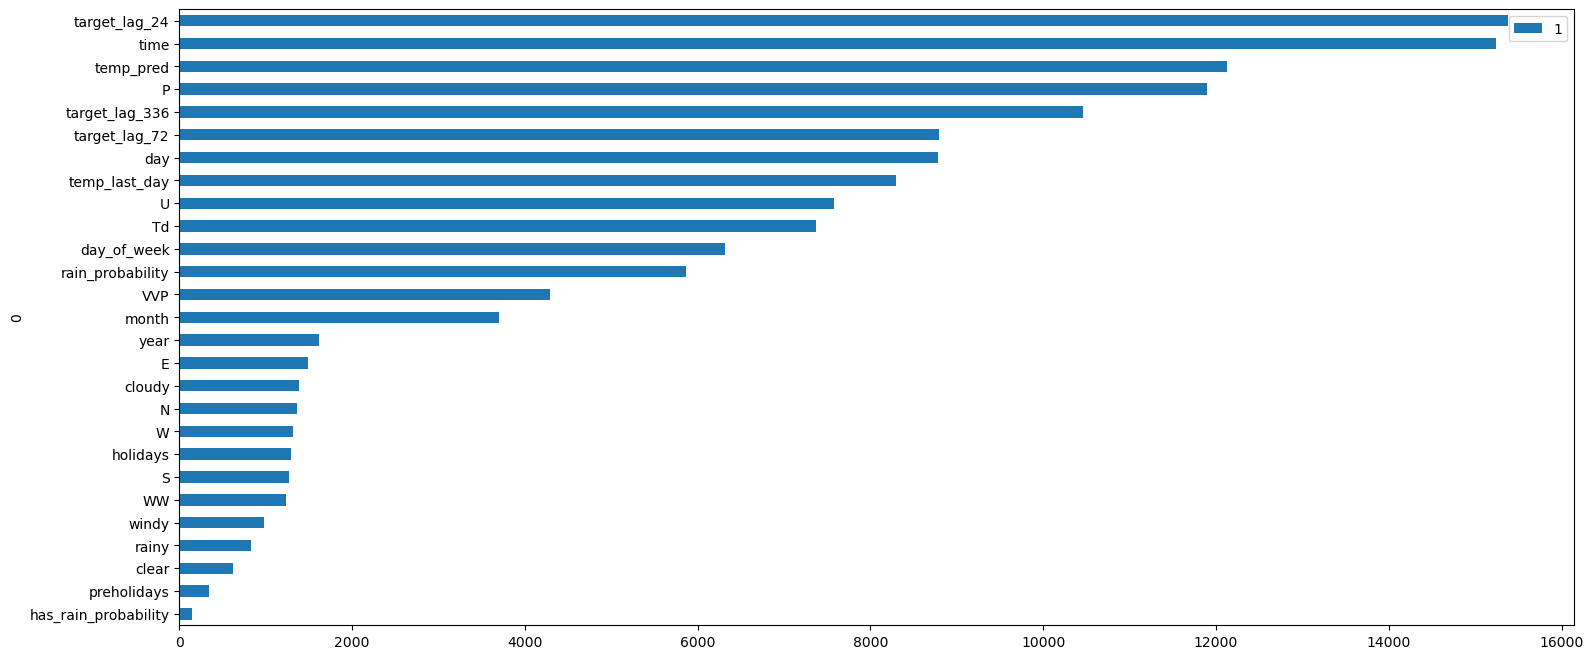

In [149]:
# График важности признаков

tmp_feature_cols = feat_lgbm_train.columns

feature_importances = pd.DataFrame([tmp_feature_cols, lgbm_model_all_train.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 8))

#### 4.2 XGBoost

In [150]:
features_all_train.columns

Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
       'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
       'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
       'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
       'S', 'W', 'E'],
      dtype='object')

In [155]:
drop_list = [#'preholidays',
            #'has_rain_probability', 
            #'holidays', 
            # 'W', 'E'
            ]
feat_xgb_train = features_all_train.drop(columns=drop_list)
feat_xgb_test = features_open_test.drop(columns=drop_list)
feat_xgb_train.columns, feat_xgb_test.columns

(Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
        'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
        'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
        'S', 'W', 'E'],
       dtype='object'),
 Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays',
        'preholidays', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear',
        'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N',
        'S', 'W', 'E'],
       dtype='object'))

In [156]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете


xgb_model_all_train = xgb_model.fit(feat_xgb_train, target_all_train)

mae_train, mape_train, r2_train = metrics_hour(target_all_train, xgb_model_all_train.predict(feat_xgb_train))
mae_open_test, mape_open_test, r2_open_test = metrics_hour(target_open_test, xgb_model_all_train.predict(feat_xgb_test))

results = pd.concat([results,
pd.DataFrame([[f'тренировочная XGB {FEATURES}', mae_train, mape_train, r2_train], [f'тестовая XGB {FEATURES}', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))
 ])


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [158]:
results.to_csv(f'results_LGBM_XGBoost_{FEATURES}_xgb_all_feature')

In [157]:
results

,Выборка,MAE,MAPE,R2
0,тренировочная LGBM _Aug_100,4.413323,0.009581,0.994825
1,тестовая LGBM _Aug_100,6.786396,0.016088,0.982338
0,тренировочная XGB _Aug_100,4.083976,0.008821,0.997174
1,тестовая XGB _Aug_100,7.014886,0.016539,0.981304
0,тренировочная XGB _Aug_100,4.052647,0.008739,0.997200
1,тестовая XGB _Aug_100,6.894478,0.016212,0.982032
